In [ ]:
pip install geopandas matplotlib

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import geopandas as gpd
%matplotlib inline
sns.set(color_codes=True)

# When And Where To Invest

In order to understand if we should wait to invest or should I invest now we can look at the Zillow's forecast. The forecast dataset contains *home values* based on a Zillow's Home Value Index. The dataset predicts the home value for November 2024, January 2025 and October 2025. 

The Home Value Index is calculated based on multiple features that the Zillow website collects.

> The core tech for the previous Zestimate algorithm used random forests, an algorithmic approach that filtered homes into ever narrowing price buckets using property and listing information. The end result is a set of similar homes with prices that jointly minimizes the error between the model’s predictions (the Zestimates) and actual, observed sale prices. the new neural network-based approach has several major advantages. First and foremost, it can handle A LOT more data allowing the models to learn about the price of homes across time and beyond county borders flexibly and responsively.

The dataset contains the `zip` code and the `RegionID` which can be used later to select the geographical area in the United States that we can invest.

We will be using the Zillow's Median Sale Prices Adjusted dataset to understand what are the median house price for the identified investment will be, to check if we follow the 12 million dollars budget.

In [2]:
# Loading the dataset that we will be using
meadianSalePrices = pd.read_csv('./data/median_sale_prices_adjusted.csv')
forecastByZip = pd.read_csv('./data/forecast_zip.csv')

# Loading zip and state
# Source: https://www.census.gov/cgi-bin/geo/shapefiles/index.php
zip_codes = gpd.read_file("../data/tl_2024_us_zcta520/tl_2024_us_zcta520.shp")
us_states = gpd.read_file('../data/tl_2024_us_state/tl_2024_us_state.shp')

# Removing unincorporated territories
us_states = us_states[~us_states.STATEFP.isin(["72", "69", "60", "66", "78"])]

# Center to us continental
# Source: https://dev.to/oscarleo/how-to-create-data-maps-of-the-united-states-with-matplotlib-p9i
us_states = us_states.to_crs("ESRI:102003")

# Move column
col_to_move = us_states.pop('STUSPS')
us_states.insert(len(us_states.columns), 'STUSPS', col_to_move)

def translate_geometries(df, x, y, scale, rotate):
    df.loc[:, "geometry"] = df.geometry.translate(yoff=y, xoff=x)
    center = df.dissolve().centroid.iloc[0]
    df.loc[:, "geometry"] = df.geometry.scale(xfact=scale, yfact=scale, origin=center)
    df.loc[:, "geometry"] = df.geometry.rotate(rotate, origin=center)
    return df

def adjust_maps(df):
    df_main_land = df[~df.STATEFP.isin(["02", "15"])]
    df_alaska = df[df.STATEFP == "02"]
    df_hawaii = df[df.STATEFP == "15"]

    df_alaska = translate_geometries(df_alaska, 1300000, -4900000, 0.5, 32)
    df_hawaii = translate_geometries(df_hawaii, 5400000, -1500000, 1, 24)

    return pd.concat([df_main_land, df_alaska, df_hawaii])

us_states = adjust_maps(us_states)

In [3]:
print(zip_codes.head())
print(zip_codes.dtypes)
print(us_states.head())
print(us_states.dtypes)
print('Zillow Forecast of Home Values dataset')
print(f'Size: {len(forecastByZip)}')
print(forecastByZip.dtypes)
display(forecastByZip.head())
print('US Median Sale Price dataset')
print(f'Size: {len(meadianSalePrices)}')
print(meadianSalePrices.dtypes)
display(meadianSalePrices.head())

  ZCTA5CE20 GEOID20       GEOIDFQ20 CLASSFP20 MTFCC20 FUNCSTAT20  ALAND20  \
0     47236   47236  860Z200US47236        B5   G6350          S  1029063   
1     47870   47870  860Z200US47870        B5   G6350          S     8830   
2     47851   47851  860Z200US47851        B5   G6350          S    53326   
3     47337   47337  860Z200US47337        B5   G6350          S   303089   
4     47435   47435  860Z200US47435        B5   G6350          S    13302   

   AWATER20   INTPTLAT20    INTPTLON20  \
0         0  +39.1517426  -085.7252769   
1         0  +39.3701518  -087.4735141   
2         0  +39.5735839  -087.2459559   
3         0  +39.8027537  -085.4372850   
4         0  +39.2657557  -086.2951577   

                                            geometry  
0  POLYGON ((-85.7341 39.15597, -85.72794 39.1561...  
1  POLYGON ((-87.47414 39.37016, -87.47409 39.370...  
2  POLYGON ((-87.24769 39.5745, -87.24711 39.5744...  
3  POLYGON ((-85.44357 39.80328, -85.44346 39.803...  
4  POLYGO

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,BaseDate,2024-11-30,2025-01-31,2025-10-31
0,91982,1,77494,zip,TX,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,2024-10-31,0.0,-0.2,0.6
1,61148,2,8701,zip,NJ,NJ,Lakewood,"New York-Newark-Jersey City, NY-NJ-PA",Ocean County,2024-10-31,0.4,0.6,1.8
2,91940,3,77449,zip,TX,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Harris County,2024-10-31,-0.3,-0.8,0.3
3,62080,4,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,2024-10-31,-0.1,-0.3,0.5
4,91733,5,77084,zip,TX,TX,Houston,"Houston-The Woodlands-Sugar Land, TX",Harris County,2024-10-31,-0.2,-0.6,0.4


US Median Sale Price dataset
Size: 714
RegionID        int64
SizeRank        int64
RegionName     object
RegionType     object
StateName      object
               ...   
2024-05-31    float64
2024-06-30    float64
2024-07-31    float64
2024-08-31    float64
2024-09-30    float64
Length: 79, dtype: object


,RegionID,SizeRank,RegionName,RegionType,StateName,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,...,2023-12-31,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30
0,102001,0,United States,country,NaN,226464.0,225849.0,226543.0,227654.0,228643.0,...,334503.0,335121.0,339431.0,345202.0,349125.0,352081.0,355144.0,357383.0,358468.0,358221.0
1,394913,1,"New York, NY",msa,NY,397636.0,395248.0,395611.0,396926.0,396567.0,...,603185.0,605647.0,608658.0,612170.0,617987.0,627793.0,641076.0,651363.0,655123.0,654488.0
2,753899,2,"Los Angeles, CA",msa,CA,673718.0,669784.0,670135.0,668451.0,663329.0,...,919376.0,917801.0,923357.0,932840.0,948535.0,958927.0,969256.0,970001.0,956885.0,944886.0
3,394463,3,"Chicago, IL",msa,IL,229945.0,228880.0,229653.0,231949.0,231769.0,...,298526.0,300513.0,302807.0,306239.0,308296.0,311049.0,315312.0,320457.0,320957.0,322567.0
4,394514,4,"Dallas, TX",msa,TX,258925.0,254695.0,252172.0,251891.0,252191.0,...,381933.0,383066.0,385045.0,389886.0,391964.0,393948.0,392894.0,392275.0,391197.0,390032.0


### Data Cleaning Of The Forecast Dataset

We have decided to not remove any empty values, because the `City` and the `Metro` value can be infer it by the zip code or other data.

The `RegionName` column in reality is the `ZipCode` which we will rename.

In [4]:
# Data Cleaning Forecast By Zip
forecastByZip = forecastByZip.rename(columns={'RegionName': 'ZipCode'})
forecastByZip['ZipCode'] = forecastByZip['ZipCode'].astype(str).str.zfill(5)
print(f'Number of duplicate rows: {forecastByZip[forecastByZip.duplicated()].shape}')
print()
print(f'Number of rows:\n{forecastByZip.count()}')
print()
print('Number of empty rows:')
print(forecastByZip.isnull().sum())

Number of duplicate rows: (0, 13)

Number of rows:
RegionID      20161
SizeRank      20161
ZipCode       20161
RegionType    20161
StateName     20161
State         20161
City          19502
Metro         20091
CountyName    20161
BaseDate      20161
2024-11-30    20161
2025-01-31    20161
2025-10-31    20161
dtype: int64

Number of empty rows:
RegionID        0
SizeRank        0
ZipCode         0
RegionType      0
StateName       0
State           0
City          659
Metro          70
CountyName      0
BaseDate        0
2024-11-30      0
2025-01-31      0
2025-10-31      0
dtype: int64


### Data Exploration: The Zillow Forecast Of Home Values

With boxplots and histograms we are able to better understand how the data is distributed. It looks like that the more you wait the higher prices will grow. From the Zillow's forcast models we noticed that the average home value will increase by 1.7 points in the month of October 2025.

In [5]:
nov_2024_avg = np.around(forecastByZip['2024-11-30'].mean(), decimals=4, out=None)
jan_2025_avg = np.around(forecastByZip['2025-01-31'].mean(), decimals=4, out=None)
oct_2025_avg = np.around(forecastByZip['2025-10-31'].mean(), decimals=4, out=None)

print(f'November 2024 average forcast: {nov_2024_avg}')
print(f'January 2025 average forcast: {jan_2025_avg}')
print(f'October 2025 average forcast: {oct_2025_avg}')

November 2024 average forcast: 0.0934
January 2025 average forcast: 0.3384
October 2025 average forcast: 1.7423


In [6]:
forecast_min_value = min(forecastByZip['2024-11-30'].min(), forecastByZip['2025-01-31'].min(), forecastByZip['2025-10-31'].min())
forecast_max_value = max(forecastByZip['2024-11-30'].max(), forecastByZip['2025-01-31'].max(), forecastByZip['2025-10-31'].max())

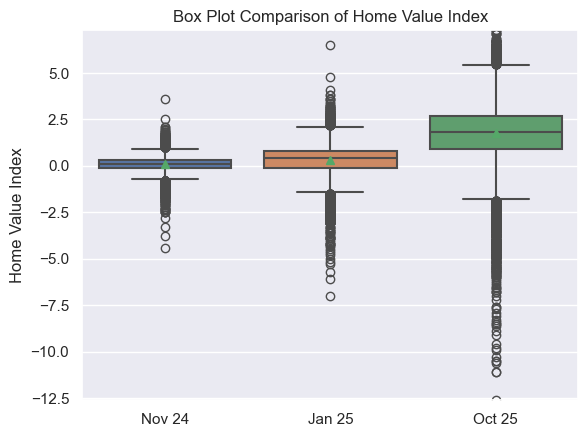

In [7]:
boxplot_data = [forecastByZip['2024-11-30'], forecastByZip['2025-01-31'], forecastByZip['2025-10-31']]
sns.boxplot(
    data=boxplot_data,
    showmeans=True,
    linewidth=1.5
)
plt.xticks([0, 1, 2], ['Nov 24', 'Jan 25', 'Oct 25'])
plt.ylabel('Home Value Index')
plt.title('Box Plot Comparison of Home Value Index')
plt.xlim(-0.5, 2.5)  # Adjust limits as needed
plt.ylim(forecast_min_value, forecast_max_value)
plt.show()

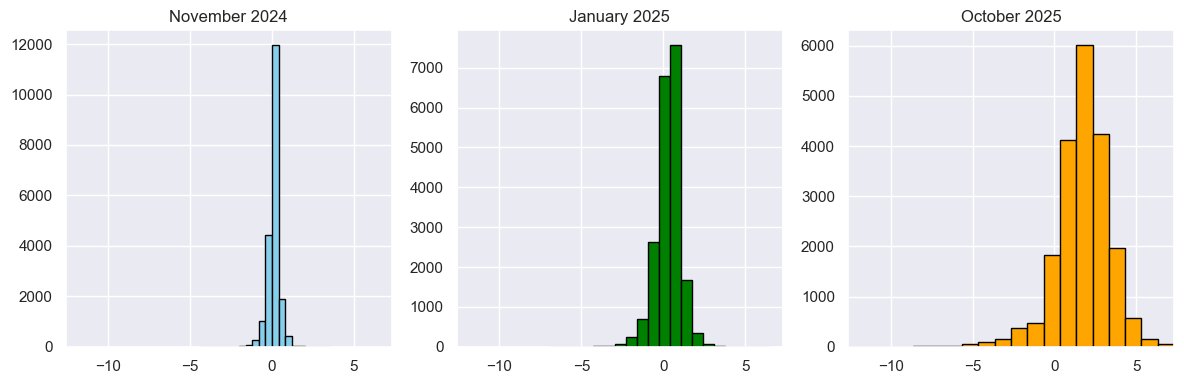

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
axes[0].hist(forecastByZip['2024-11-30'], bins=20, color='skyblue', edgecolor='black')
axes[0].set_title('November 2024')
axes[0].set_xlim(forecast_min_value, forecast_max_value)
axes[1].hist(forecastByZip['2025-01-31'], bins=20, color='green', edgecolor='black')
axes[1].set_title('January 2025')
axes[1].set_xlim(forecast_min_value, forecast_max_value)
axes[2].hist(forecastByZip['2025-10-31'], bins=20, color='orange', edgecolor='black')
axes[2].set_title('October 2025')
axes[2].set_xlim(forecast_min_value, forecast_max_value)
plt.tight_layout()
plt.show()

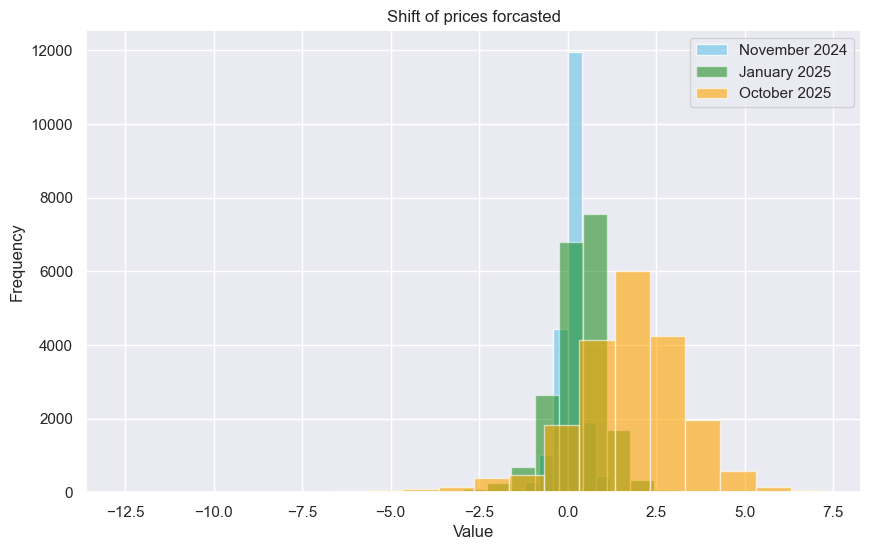

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(forecastByZip['2024-11-30'], bins=20, color='skyblue', alpha=0.8, label='November 2024')
ax.hist(forecastByZip['2025-01-31'], bins=20, color='green', alpha=0.5, label='January 2025')
ax.hist(forecastByZip['2025-10-31'], bins=20, color='orange', alpha=0.6, label='October 2025')
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.set_title('Shift of prices forcasted')
ax.legend()
plt.show()

### Buying Now To Sell In October 2025

The boxplots and the histograms are showing that the prices of some houses will eventually increase by October 2025. Based on Zillow's forcasting model.

Overall, Zillow is forcasting that Home Values will increase until October 2025, therefore we should be investing now in the geographical regions that will have the highest Home Value forecast increase.

### Exploring Where To Invest

By looking at the highest home values increase by October 2025, we can investage to invest in:
- Berlin, NH
- Stratford, NH
- Clewiston, FL
- Stockett, MT
- Margate City, NJ
- Longport, NJ
- Felda, FL
- Lake Toxaway, NC
- Atlantic City, NJ
- Pine Hill, NY

In [10]:
top10_nov24 = forecastByZip.nlargest(10, '2024-11-30')
top10_jan25 = forecastByZip.nlargest(10, '2025-01-31')
top10_nov25 = forecastByZip.nlargest(10, '2025-10-31')
display(top10_nov24[['RegionID', 'City', 'StateName', '2024-11-30']])
display(top10_jan25[['RegionID', 'City', 'StateName', '2025-01-31']])
display(top10_nov25[['RegionID', 'City', 'StateName', '2025-10-31']])

,RegionID,City,StateName,2024-11-30
11846,79944,Kincheloe,MI,3.6
15885,62218,Great River,NY,2.5
16634,60156,Hartford,CT,2.1
16881,84985,La Harpe,IL,2.1
15725,86235,Senath,MO,2.0
14101,85558,Mount Pulaski,IL,1.9
16249,81459,Cassville,WI,1.9
17031,85188,Fithian,IL,1.8
17193,85224,Ashmore,IL,1.8
17552,85597,NaN,IL,1.8


,RegionID,City,StateName,2025-01-31
11846,79944,Kincheloe,MI,6.5
15885,62218,Great River,NY,4.8
16881,84985,La Harpe,IL,4.1
16249,81459,Cassville,WI,3.8
17859,75543,Payneville,KY,3.8
14116,65577,Luzerne,PA,3.6
17613,85167,Bismarck,IL,3.6
18856,74967,Clarksdale,MS,3.6
16634,60156,Hartford,CT,3.5
17031,85188,Fithian,IL,3.4


,RegionID,City,StateName,2025-10-31
9431,59145,Berlin,NH,7.3
17267,59159,Stratford,NH,7.3
5464,72606,Clewiston,FL,7.2
17675,84083,Stockett,MT,7.2
11579,61075,Margate City,NJ,7.1
17929,61076,Longport,NJ,7.1
19663,72919,Felda,FL,7.1
15791,70191,Lake Toxaway,NC,6.9
2131,61074,Atlantic City,NJ,6.8
19631,62588,Pine Hill,NY,6.8


### Finding Where To Buy

Now that we know some of the , we can decide to invest in the area where the median home prices are the lowest.

In [11]:
# Merge the dataframe on RegionID
merged_df_median_sale_by_regionID = top10_nov25.merge(meadianSalePrices, on='RegionID')
# This returned an empty dataframe, because the median dataset does not have these regionID
print(f'Size of median sale price by RegionID: {len(merged_df_median_sale_by_regionID)} \n')
# We can now try it by finding the Median Sale Price of the City
top10_nov25['CityState'] = top10_nov25['City'] + ', ' + top10_nov25['StateName']
print(top10_nov25['CityState'])

Size of median sale price by RegionID: 0 

9431            Berlin, NH
17267        Stratford, NH
5464         Clewiston, FL
17675         Stockett, MT
11579     Margate City, NJ
17929         Longport, NJ
19663            Felda, FL
15791     Lake Toxaway, NC
2131     Atlantic City, NJ
19631        Pine Hill, NY
Name: CityState, dtype: object


In [12]:
# Check if the dataframe contains the CityState
print(f'Atlantic City, NJ found: {len(meadianSalePrices[meadianSalePrices['RegionName'] == 'Atlantic City, NJ'])}')
print(f'Berlin, NH not found: {len(meadianSalePrices[meadianSalePrices['RegionName'] == 'Berlin, NH'])}')
print(f'Stratford, NH not found: {len(meadianSalePrices[meadianSalePrices['RegionName'] == 'Stratford, NH'])}')

# Something we could have done if we had the data
top10_nov25Copy = top10_nov25
col_to_move = top10_nov25Copy.pop('CityState')
top10_nov25Copy.insert(len(top10_nov25Copy.columns), 'CityState', col_to_move)
merged_df_median_sale_by_citystate = top10_nov25Copy.merge(meadianSalePrices, left_on='CityState', right_on='RegionName')
display(merged_df_median_sale_by_citystate)

Atlantic City, NJ found: 1
Berlin, NH not found: 0
Stratford, NH not found: 0


,RegionID_x,SizeRank_x,ZipCode,RegionType_x,StateName_x,State,City,Metro,CountyName,BaseDate,...,2023-12-31,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30
0,72606,5571,33440,zip,FL,FL,Clewiston,"Clewiston, FL",Hendry County,2024-10-31,...,54867.0,50522.0,44103.0,62821.0,94934.0,94676.0,91307.0,93436.0,137805.0,165601.0
1,61074,2168,08401,zip,NJ,NJ,Atlantic City,"Atlantic City-Hammonton, NJ",Atlantic County,2024-10-31,...,342057.0,334362.0,342081.0,343941.0,350880.0,357040.0,353469.0,349884.0,345772.0,347741.0


The Median Price Sale dataset does not contian all cities in the United States. Therefore we don't have the data to determine which city is cheaper to invest.

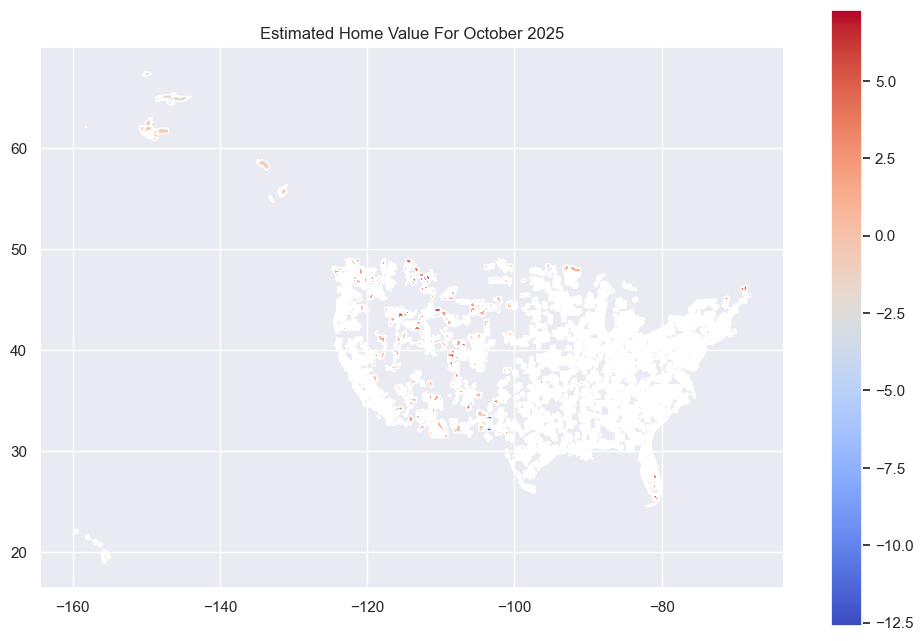

In [13]:
forecastByZipCopy = forecastByZip

col_to_move = forecastByZipCopy.pop('ZipCode')
forecastByZipCopy.insert(len(forecastByZipCopy.columns), 'ZipCode', col_to_move)
map_zip_df = zip_codes.merge(forecastByZipCopy, left_on='ZCTA5CE20', right_on='ZipCode')

fig, ax = plt.subplots(1, figsize=(12, 8))
map_zip_df.plot(column='2025-10-31', cmap='coolwarm', ax=ax, legend=True)
ax.set_title('Estimated Home Value For October 2025')
#ax.axis('off')
plt.show()

In [14]:
forecastByState = forecastByZipCopy.groupby('StateName')['2025-10-31'].mean().reset_index()
top5StatesForOct24 = forecastByState.nlargest(10, '2025-10-31')
print(top5StatesForOct24)

   StateName  2025-10-31
21        ME    4.450704
26        MT    4.228736
30        NH    4.227215
6         CT    3.624324
39        RI    3.536232
13        ID    3.022667
42        TN    3.008409
15        IN    2.980492
27        NC    2.801997
8         DE    2.733898


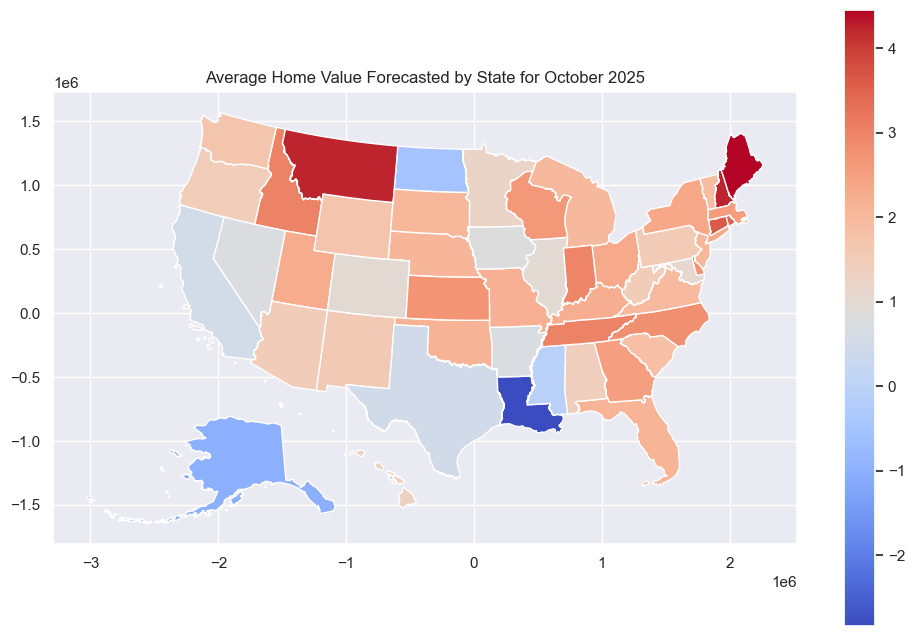

In [15]:
forecast_map_state_df = us_states.merge(forecastByState, left_on='STUSPS', right_on='StateName')

fig, ax = plt.subplots(1, figsize=(12, 8))
forecast_map_state_df.plot(column='2025-10-31', cmap='coolwarm', ax=ax, legend=True)
ax.set_title('Average Home Value Forecasted by State for October 2025')
plt.show()

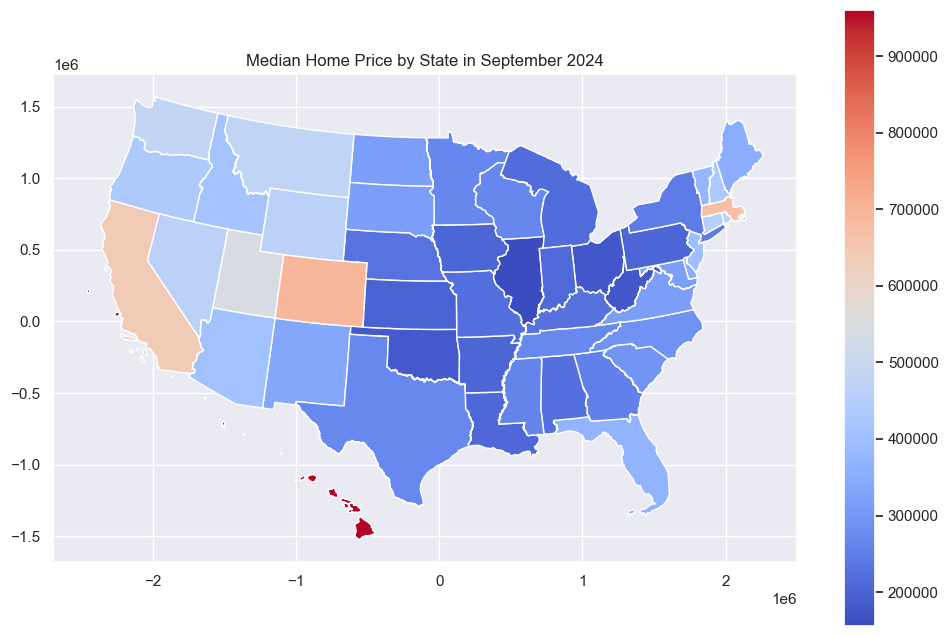

In [16]:
medianSalesCopy = meadianSalePrices

medianSalesByState = medianSalesCopy.groupby('StateName')['2024-09-30'].mean().reset_index()
col_to_move = medianSalesByState.pop('StateName')
medianSalesByState.insert(len(medianSalesByState.columns), 'StateName', col_to_move)
map_states_median_df = us_states.merge(medianSalesByState, left_on='STUSPS', right_on='StateName')

fig, ax = plt.subplots(1, figsize=(12, 8))
map_states_median_df.plot(column='2024-09-30', cmap='coolwarm', ax=ax, legend=True)
ax.set_title('Median Home Price by State in September 2024')
plt.show()

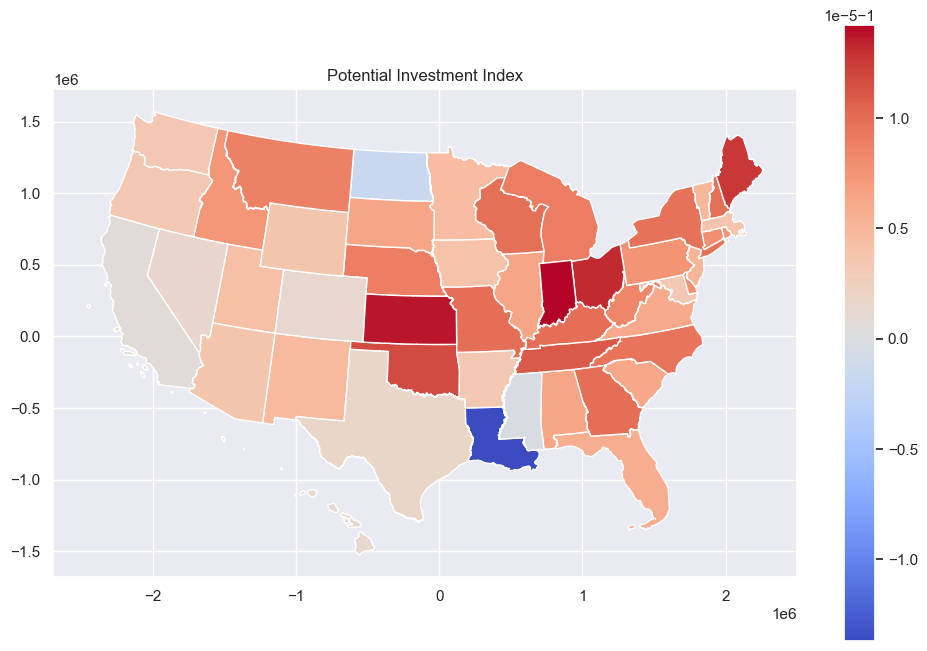

In [17]:
median_value_df = forecastByState.merge(medianSalesByState)
median_value_df = median_value_df.rename(columns={'2025-10-31': 'HomeValue', '2024-09-30': 'MedianPrice'})
median_value_df['PotentialInvestmentIndex'] = (median_value_df['HomeValue'] / median_value_df['MedianPrice']) - 1

map_states_pip_df = us_states.merge(median_value_df, left_on='STUSPS', right_on='StateName')

fig, ax = plt.subplots(1, figsize=(12, 8))
map_states_pip_df.plot(column='PotentialInvestmentIndex', cmap='coolwarm', ax=ax, legend=True)
ax.set_title('Potential Investment Index')
plt.show()

In [18]:
top = top10_nov25.merge(median_value_df, on='StateName')
top = top.rename(columns={'HomeValue': 'StateHomeValue', '2025-10-31': 'ForecastedHomeValue'})
top = top[['City', 'StateName', 'ForecastedHomeValue', 'StateHomeValue', 'MedianPrice', 'PotentialInvestmentIndex']]
display(top)

,City,StateName,ForecastedHomeValue,StateHomeValue,MedianPrice,PotentialInvestmentIndex
0,Berlin,NH,7.3,4.227215,429470.500000,-0.999990
1,Stratford,NH,7.3,4.227215,429470.500000,-0.999990
2,Clewiston,FL,7.2,2.108266,368253.230769,-0.999994
3,Stockett,MT,7.2,4.228736,477568.714286,-0.999991
4,Margate City,NJ,7.1,2.051920,396868.250000,-0.999995
5,Longport,NJ,7.1,2.051920,396868.250000,-0.999995
6,Felda,FL,7.1,2.108266,368253.230769,-0.999994
7,Lake Toxaway,NC,6.9,2.801997,292866.243243,-0.999990
8,Atlantic City,NJ,6.8,2.051920,396868.250000,-0.999995
9,Pine Hill,NY,6.8,2.362529,244207.520000,-0.999990


![Berlin](https://img.bestplaces.net/images/states/new_hampshire.jpg)

### Conclusions: Invest In Berlin, Stratford And Pine Hill

Based on the Forcasted Home Value, it would be good to invest today in either New Hampshire, Florida, Montana, New Jersey, North Carolina and New York.

Investing in Pine Hill, New York, would be a great place to invest in case it is important to invest in multiple cheaper houses, because the state median price in September 2024 is the lowest and the forecasted Home Value will increase by the end of 2025. Although if there are no restrctions in the Median Price, Berlin or Stratford, New Hampshire, are the best cities to invest and buy a home, because the Forecasted Home Value for 2025 will be the highest.